## TITANIC DATASET

In [2]:
import numpy as np
import pandas as pd

## Data Analysis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline
plt.style.use("seaborn")

### Data Preparation

Read titanic data and store it into a pandas DataFrame

In [4]:
df = pd.read_csv("_Titanic/titanic.csv")

df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Check for missing values and compute missing rates

In [5]:
count = df.isna().sum()
rate = pd.Series([nan/df.shape[0] for nan in count], index=df.columns)
frequency = pd.Series([nan/df.iloc[:, i].count() for i, nan in enumerate(count)], index=df.columns)

missing = pd.DataFrame(pd.concat([count, rate, frequency], axis=1)).replace(0, np.nan)
missing.columns = ["Missing", "Missing/Total", "Missing/NotMissing"]

missing

,Missing,Missing/Total,Missing/NotMissing
PassengerId,NaN,NaN,NaN
Survived,NaN,NaN,NaN
Pclass,NaN,NaN,NaN
Name,NaN,NaN,NaN
Sex,NaN,NaN,NaN
Age,177.0,0.198653,0.247899
SibSp,NaN,NaN,NaN
Parch,NaN,NaN,NaN
Ticket,NaN,NaN,NaN
Fare,NaN,NaN,NaN


Fill Embarked column missing values by randomly assigning existing ones

In [6]:
df["Embarked"].fillna(lambda x: random.choice(df[df[column] != np.nan]["Embarked"]), inplace =True)

Drop Cabin column, as it mostly contains missing values

In [7]:
df.drop("Cabin", inplace=True, axis=1)

Drop Age column missing value rows to lower model bias

In [8]:
df.dropna(inplace=True, axis=0)

### Feature Engineering

Drop SibSp and Parch columns after calculating total family to ensure model simplicity

In [9]:
df["Family"] = df.SibSp + df.Parch
df.drop(["SibSp", "Parch"], inplace=True, axis=1)

Drop PassengerId, Name, Ticket and Fare columns, as they are easily predicted to not have correlation with survival

In [10]:
df.drop(["PassengerId", "Name", "Ticket", "Fare"], inplace=True, axis=1)

Search for correlated features using seaborn heatmap

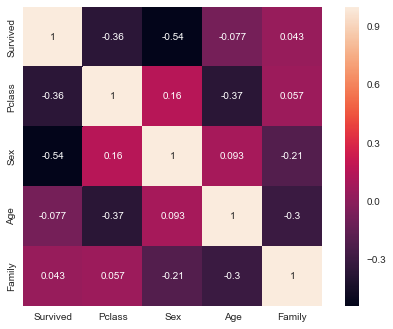

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode male and female to binary values to better correlate them
temp_df = df.copy()
temp_df["Sex"] = LabelEncoder().fit(["male","female"]).transform(temp_df.Sex)

# Correlation matrix
correlation = temp_df.corr()

# Heatmap plot
sns.heatmap(correlation, 
            annot=True, 
            square=True)

# Plot parameters
plt.yticks(va="center")
plt.ylim(len(correlation), 0);

Plot Sex and Pclass survival correlation using matplotlib countplot

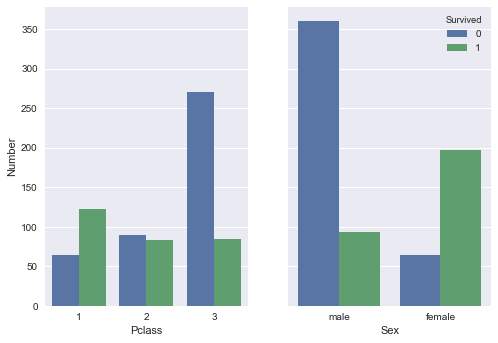

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Countplot
for x, ax in zip(["Pclass", "Sex"], fig.axes):
    sns.countplot(x=x, 
                  hue="Survived", 
                  data=df, 
                  ax=ax)

# Plot parameters
ax1.set_ylabel("Number")
ax2.set_ylabel("")
ax1.legend("");

Compute survival median feature values

In [13]:
survival = df.pivot_table(index="Survived")

survival

,Age,Family,Pclass
Survived,,,
0,30.626179,0.891509,2.485849
1,28.343690,1.020690,1.872414


Pclass, Age and Sex are undoubtedly realted to survival

Drop Family column, as it has a loose correlation with survival

In [14]:
df.drop("Family", inplace=True, axis=1)

## Data Visualization

Survival rates

,Count,Rate
Not_Survived,424,0.593838
Survived,290,0.406162
Total,714,


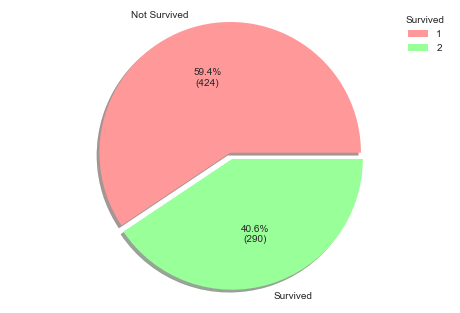

In [15]:
# Get survival count
survival = pd.DataFrame(data=df.Survived.value_counts().values, 
                        index=["Not_Survived","Survived"], 
                        columns=["Count"])

# Calculate total passengers
survival.loc["Total"] = survival.sum()
# Calculate survival rate
survival["Rate"] = [survival.Count.Not_Survived/survival.Count.Total, survival.Count.Survived/survival.Count.Total, ""]

# Format function
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Pie chart
plt.pie(survival.Count[0:2], 
        explode=[0, 0.05], 
        colors=["#ff9999", "#99ff99"], 
        labels=["Not Survived", "Survived"], 
        shadow=True, 
        autopct=lambda pct: func(pct, survival.Count[0:2]))

# Plot parameters
plt.axis("equal")
plt.legend("12", title="Survived", loc="upper right")

survival

Survival by Age and Pclass count

'Not_Survived'

,1,2,3
"(0, 16]",1,2,42
"(16, 32]",16,48,154
"(32, 48]",22,27,63
"(48, 64]",20,11,8
"(64, 80]",5,2,3


'Survived'

,1,2,3
"(0, 16]",1,2,42
"(16, 32]",16,48,154
"(32, 48]",22,27,63
"(48, 64]",20,11,8
"(64, 80]",5,2,3


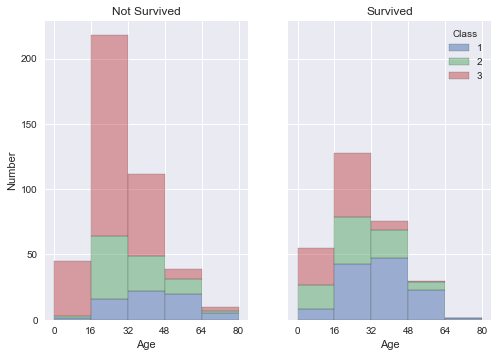

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

# Age bins
bins = [0, 16, 32, 48, 64, 80]

# Unordered survival by Age and Pclass
survived_age_pclass = [[pd.cut(df[(df.Survived == survived) & (df.Pclass == pclass)]["Age"], bins=bins).value_counts().sort_index() for pclass in np.sort(df.Pclass.unique())] for survived in df.Survived.unique()]

# Ordered survival by Age and Pclass count
survived_age_pclass_count = [pd.concat(survived_age_pclass[survived], axis=1, sort=False).astype(int) for survived in range(len(survived_age_pclass))]

for survived in range(len(survived_age_pclass_count)):
    survived_age_pclass_count[survived].columns = np.sort(df.Pclass.unique().astype(str))

# Bar plot
for i, ax in zip(range(len(survived_age_pclass_count)), [ax1, ax2]):
    bottom = 0
    for pclass in "123":
        temp_bottom = survived_age_pclass_count[i][pclass]
        ax.bar(np.arange(5), 
               temp_bottom, 
               width=1, 
               edgecolor="#000000", 
               alpha=0.5,
               bottom=bottom)
        bottom += temp_bottom
        ax.set_xlabel("Age")

# Plot parameters
ax1.set_xticks(np.linspace(-0.5, 4.5, 6))
ax1.set_xticklabels(np.linspace(0, 80, 6).astype(int))
ax1.set_title("Not Survived")
ax2.set_title("Survived")
ax1.set_ylabel("Number")
ax2.legend("123", title="Class")

display("Not_Survived", HTML(survived_age_pclass_count[0].to_html()), "Survived", HTML(survived_age_pclass_count[0].to_html()))

Survival by Sex and Age count

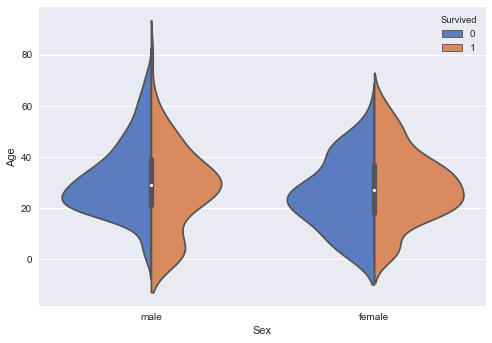

In [17]:
sns.violinplot(x="Sex", 
               y="Age", 
               hue="Survived", 
               data=df,
               palette="muted", 
               split=True)

## Machine Learning

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

### Model Training

Separate independent and dependent features

In [19]:
X = df[["Pclass", "Sex", "Age"]].copy()
y = df[["Survived"]].copy()

Encode categorical values

In [20]:
X = pd.get_dummies(X, columns=["Pclass", "Sex"])

X.head(3)

,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,0,0,1,0,1
1,38.0,1,0,0,1,0
2,26.0,0,0,1,1,0


Split train and test values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

Fit training values into model

In [22]:
model = LogisticRegression(C=1, class_weight=None, solver="lbfgs", verbose=1, random_state=None).fit(X_train, np.ravel(y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


### Model Accuracy

Compute score

In [23]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

pd.DataFrame({"Train": train_score, "Test": test_score}, index=["Score"])

,Train,Test
Score,0.788091,0.797203


Compute confusion matrix

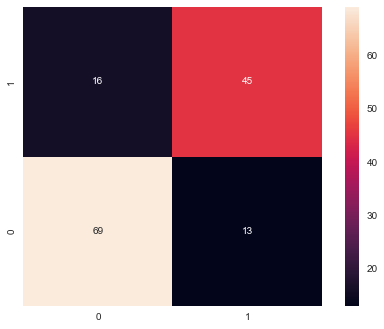

In [33]:
# Matrix
y_pred = model.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

# Heatmap plot
sns.heatmap(conf, 
            annot=True, 
            square=True)

# Plot parameters
plt.yticks(va="center")
plt.ylim(0, 2);